In [1]:
# import sys
# sys.path.append('/group/crtd_bergmann/Giovanni/software/scarches_biocluster/')

In [2]:
from collections import defaultdict
import scanpy as sc
import scanpy.external as sce
import scipy.io
# import scrublet as scr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import scvelo as scv
#import velocyto as vcy
from os import listdir
from os.path import isfile, join
import glob
from collections import Counter
import loompy as lp
import numba
import llvmlite
# import skbio

# import mnnpy
from matplotlib import colors

In [3]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [4]:
sc.settings.set_figure_params(dpi=80)
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.8.2 anndata==0.7.8 umap==0.5.3 numpy==1.21.5 scipy==1.7.3 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.6 pynndescent==0.5.7


In [5]:
import types
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__
list(imports())

['builtins',
 'builtins',
 'scanpy',
 'scanpy.external',
 'scipy',
 'pandas',
 'numpy',
 'matplotlib.pyplot',
 'itertools',
 'seaborn',
 'scvelo',
 'glob',
 'loompy',
 'numba',
 'llvmlite',
 'matplotlib.colors',
 'types']

In [6]:
def get_cluster_proportions(adata,
                            cluster_key="cluster_final",
                            sample_key="replicate",
                            drop_values=None):
    """
    Input
    =====
    adata : AnnData object
    cluster_key : key of `adata.obs` storing cluster info
    sample_key : key of `adata.obs` storing sample/replicate info
    drop_values : list/iterable of possible values of `sample_key` that you don't want
    
    Returns
    =======
    pd.DataFrame with samples as the index and clusters as the columns and 0-100 floats
    as values
    """
    
    adata_tmp = adata.copy()
    sizes = adata_tmp.obs.groupby([cluster_key, sample_key]).size()
    props = sizes.groupby(level=1).apply(lambda x: 100 * x / x.sum()).reset_index() 
    props = props.pivot(columns=sample_key, index=cluster_key).T
    props.index = props.index.droplevel(0)
    props.fillna(0, inplace=True)
    
    if drop_values is not None:
        for drop_value in drop_values:
            props.drop(drop_value, axis=0, inplace=True)
    return props


def plot_cluster_proportions(cluster_props, 
                             cluster_palette=None,
                             xlabel_rotation=1): 
    fig, ax = plt.subplots(dpi=300)
    fig.patch.set_facecolor("white")
    
    cmap = None
    if cluster_palette is not None:
        cmap = sns.palettes.blend_palette(
            cluster_palette, 
            n_colors=len(cluster_palette), 
            as_cmap=True)
   
    cluster_props.plot(
        kind="bar", 
        stacked=True, 
        ax=ax, 
        legend=None, 
        colormap=cmap
    )
    
    ax.legend(bbox_to_anchor=(1.01, 1), frameon=False, title="Cell Type")
    sns.despine(fig, ax)
    ax.tick_params(axis="x", rotation=xlabel_rotation)
    ax.set_xlabel(cluster_props.index.name.capitalize())
    ax.set_ylabel("Proportion")
    fig.tight_layout()
    
    return fig

In [7]:
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [8]:
sc.set_figure_params(dpi_save=1000)

In [9]:
adata = sc.read('./write/HiQ_final_adata.h5ad')

In [10]:
adata

AnnData object with n_obs × n_vars = 15481 × 23510
    obs: 'sample', 'batch', 'age', 'day', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'percent_mt2', 'n_counts', 'S_score', 'G2M_score', 'phase', 'pred_cell_type', 'leiden', 'dpt_pseudotime', 'draw_graph_fa_density_phase', 'cluster_name'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'age_colors', 'cluster_name_colors', 'dendrogram_cluster_name', 'dendrogram_pred_cell_type', 'diffmap_evals', 'draw_graph', 'd

In [11]:
proportions = get_cluster_proportions(adata,
                                cluster_key="pred_cell_type",
                                sample_key="sample",
                                drop_values=None)

In [12]:
proportions

pred_cell_type,EN,IN,IPC,RG
sample,,,,
d60S2,35.187581,33.505821,1.423027,29.883571
d60S3,38.643533,26.498423,1.419558,33.438486
d60S4,30.379747,34.538879,0.723327,34.358047
d90S2,59.220839,9.220839,0.899032,30.659290
d90S3,59.996002,8.756497,1.419432,29.828069
d150S2,69.517544,12.061404,0.767544,17.653509
d150S3,68.767123,10.342466,0.479452,20.410959
d150S4,63.349917,13.266998,0.829187,22.553897


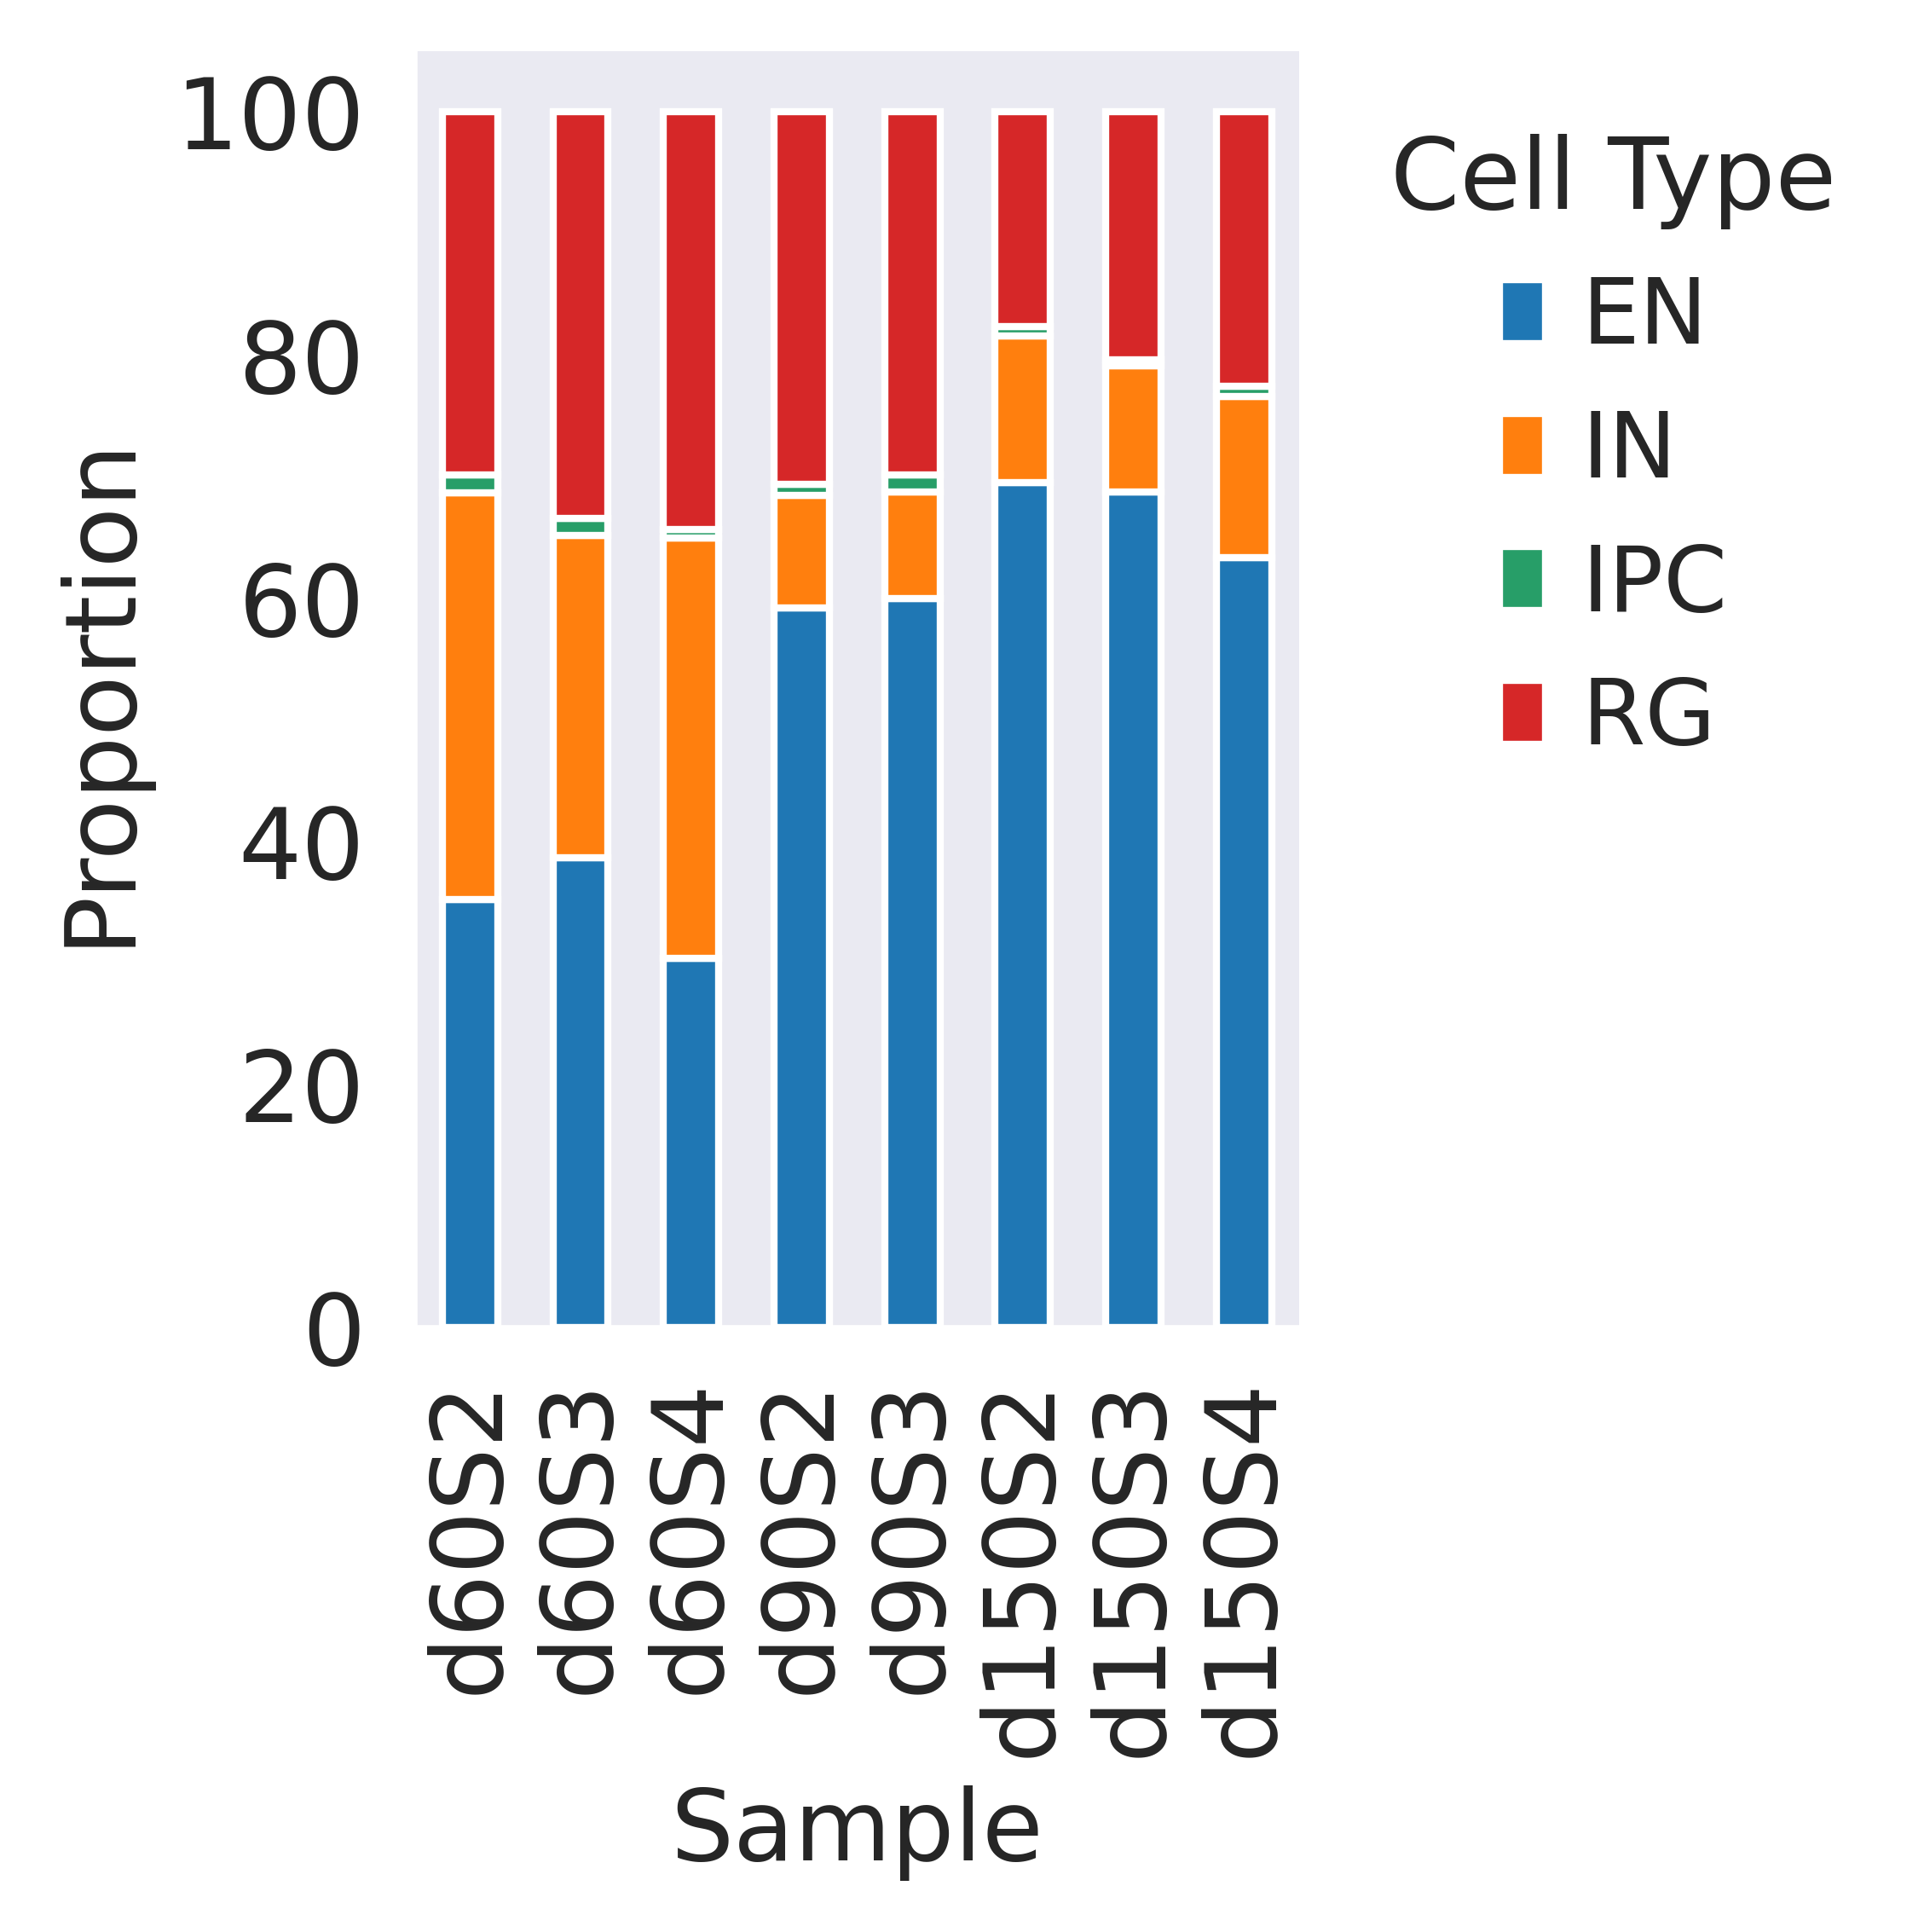

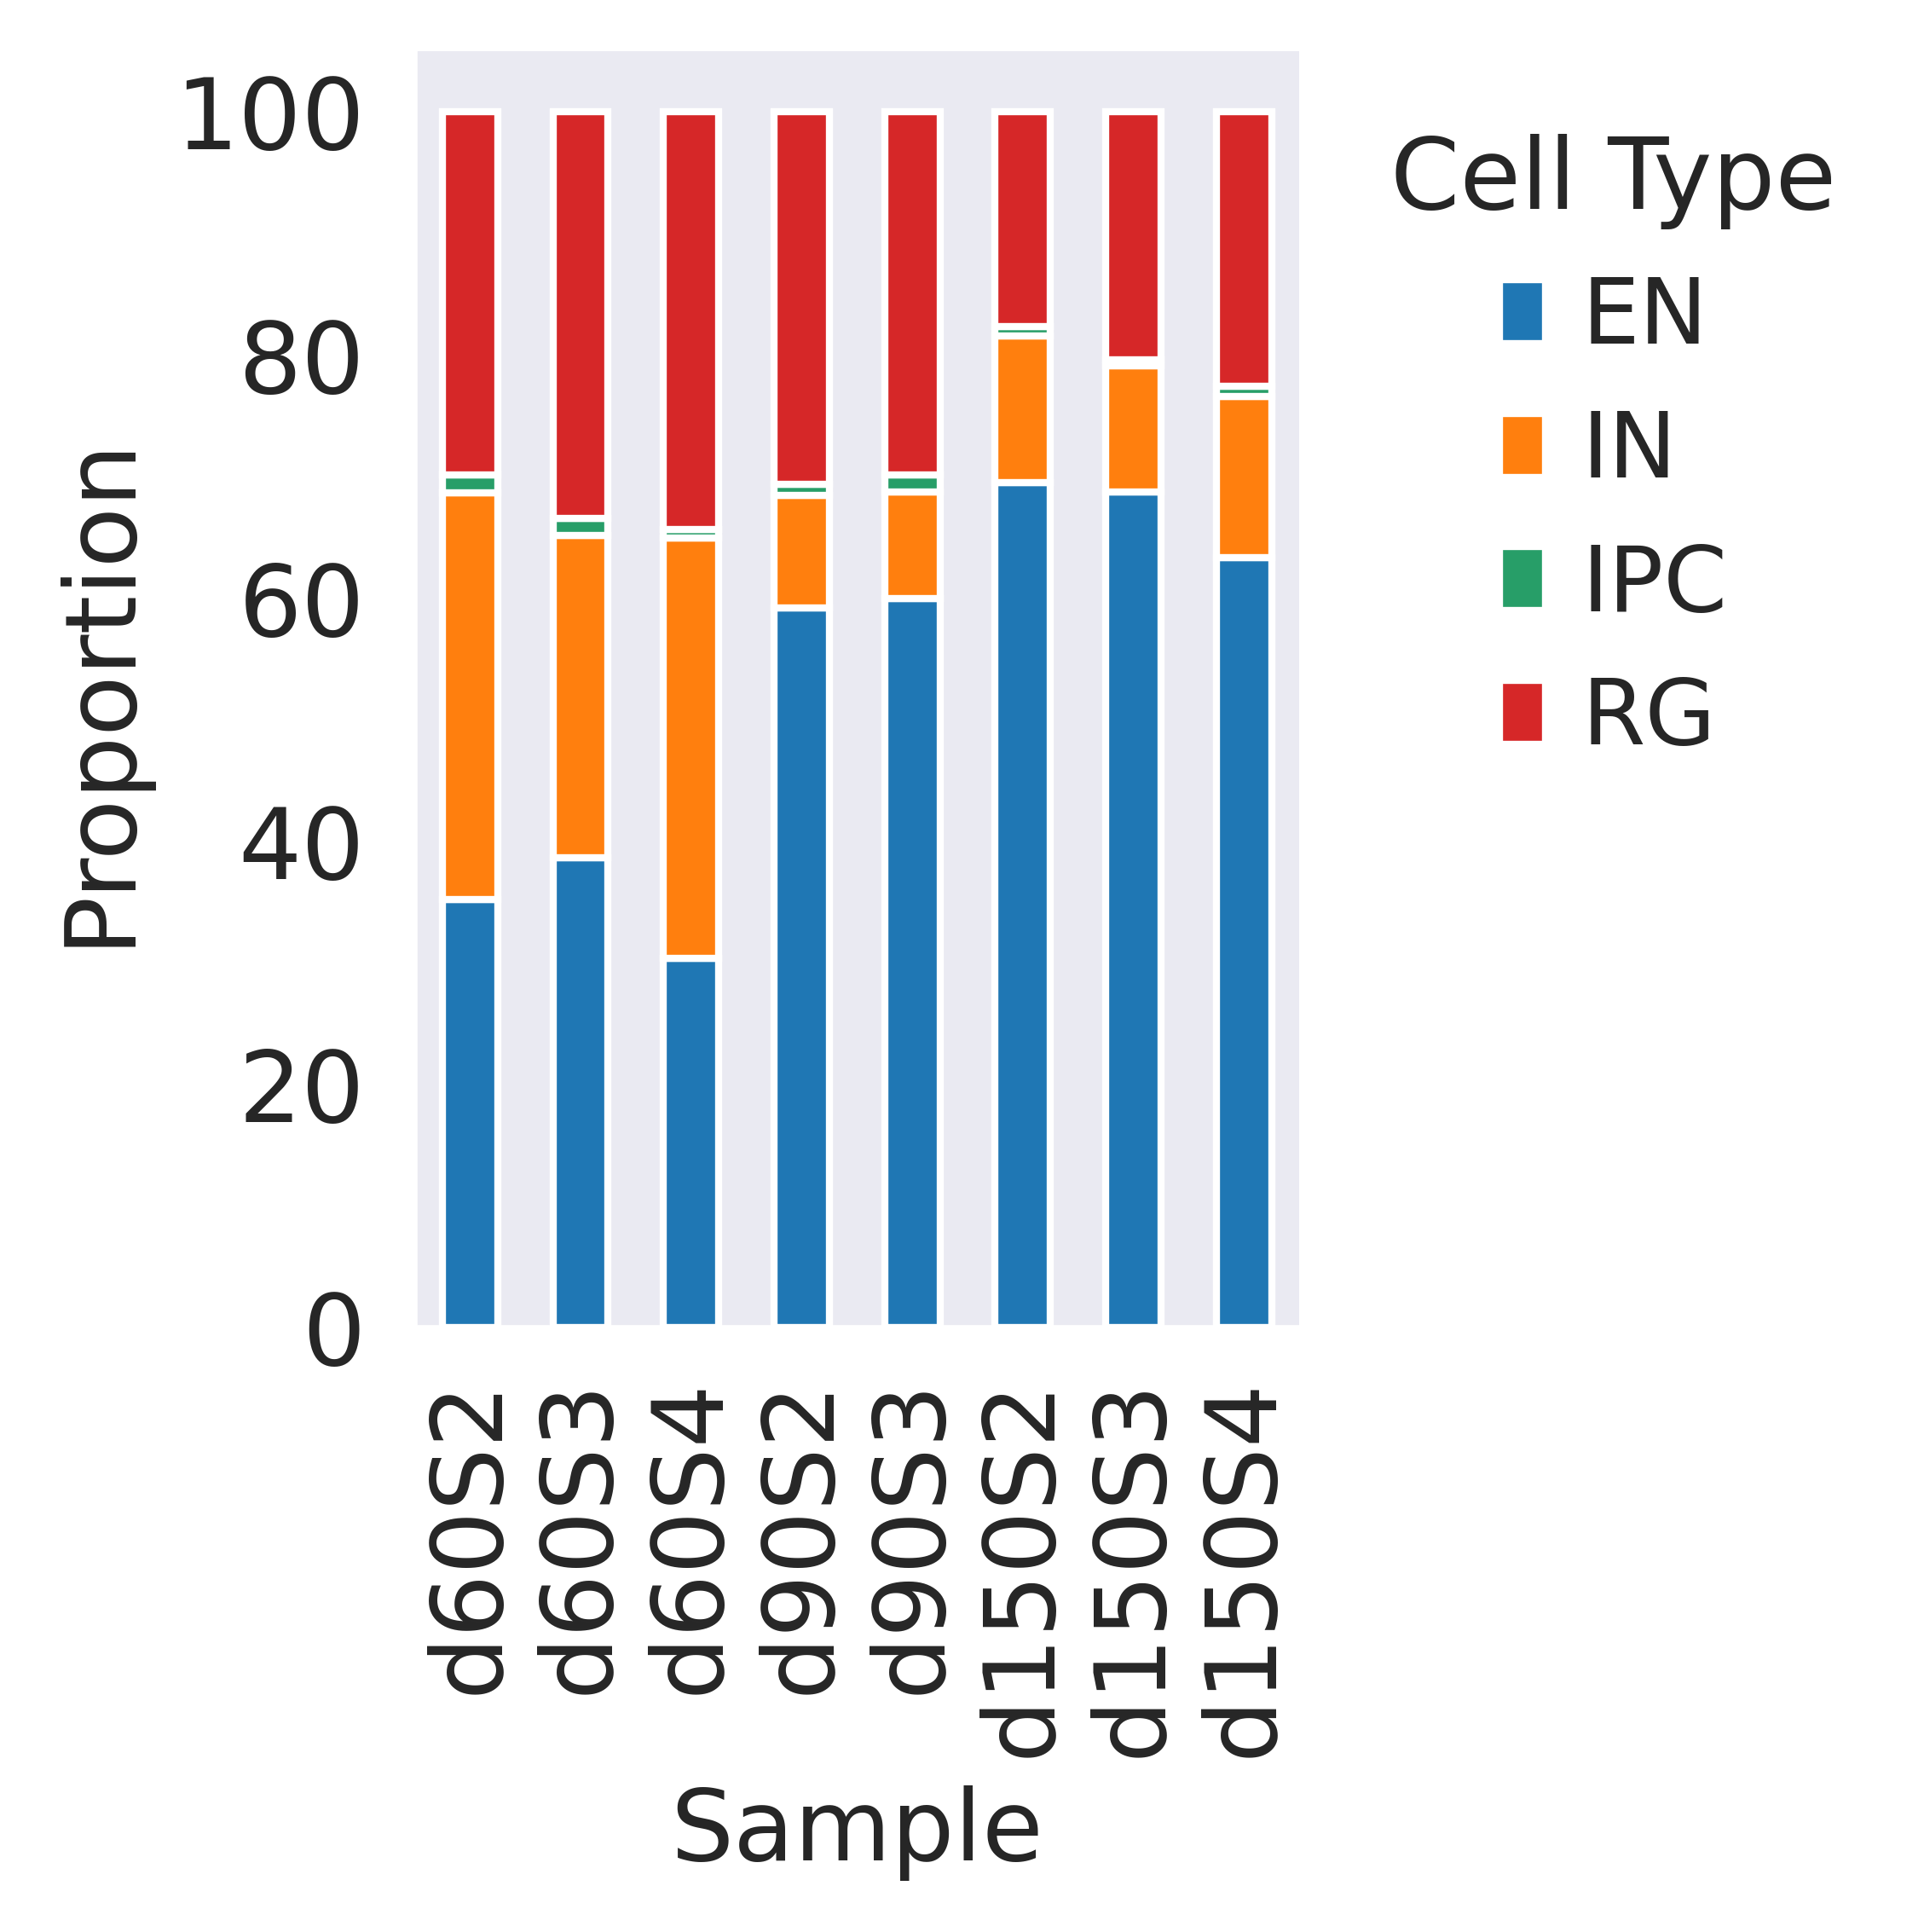

In [13]:
sns.set_style('dark')
plot_cluster_proportions(proportions, 
                             cluster_palette=None,
                             xlabel_rotation=90
                        )

In [14]:
proportions.index

CategoricalIndex(['d60S2', 'd60S3', 'd60S4', 'd90S2', 'd90S3', 'd150S2',
                  'd150S3', 'd150S4'],
                 categories=['d60S2', 'd60S3', 'd60S4', 'd90S2', 'd90S3', 'd150S2', 'd150S3', 'd150S4'], ordered=False, dtype='category', name='sample')

In [15]:
d_table = pd.DataFrame(index=proportions.index,columns=proportions.index)
# d_table

**Test proportions**

In [16]:
from scipy.spatial import distance

In [17]:

for sample in d_table.columns:
    for index,row in proportions.iterrows():
        d = distance.braycurtis(proportions.loc[sample], proportions.loc[index])
#         d = distance.jensenshannon(proportions.loc[sample], proportions.loc[index])
        d_table.loc[index,sample] = d

d_table

sample,d60S2,d60S3,d60S4,d90S2,d90S3,d150S2,d150S3,d150S4
sample,,,,,,,,
d60S2,0.0,0.070109,0.055075,0.24809,0.248084,0.3433,0.335795,0.281623
d60S3,0.070109,0.0,0.0896,0.205773,0.213525,0.30874,0.301236,0.247064
d60S4,0.055075,0.0896,0.0,0.290168,0.303124,0.39182,0.383874,0.33076
d90S2,0.24809,0.205773,0.290168,0.0,0.012956,0.131373,0.106679,0.081752
d90S3,0.248084,0.213525,0.303124,0.012956,0.0,0.128264,0.103571,0.078644
d150S2,0.3433,0.30874,0.39182,0.131373,0.128264,0.0,0.027575,0.061676
d150S3,0.335795,0.301236,0.383874,0.106679,0.103571,0.027575,0.0,0.054172
d150S4,0.281623,0.247064,0.33076,0.081752,0.078644,0.061676,0.054172,0.0


**PCoA**

In [18]:
import skbio as skb

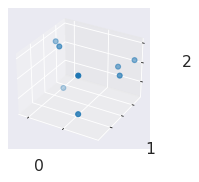

<Figure size 480x480 with 0 Axes>

In [19]:
plt.figure(figsize=(6,6))
skb.stats.ordination.pcoa(d_table, number_of_dimensions = 3)

In [20]:
pcoa_coordinates = skb.stats.ordination.pcoa(d_table, number_of_dimensions = 3).samples[['PC1', 'PC2','PC3']].set_index(d_table.index)
pcoa_coordinates["time point"] = pcoa_coordinates.index.str.replace("S.","",regex=True)
pcoa_coordinates

,PC1,PC2,PC3,time point
sample,,,,
d60S2,-0.177936,0.011641,-0.032660,d60
d60S3,-0.141859,-0.007900,0.020710,d60
d60S4,-0.228081,0.014506,0.013229,d60
d90S2,0.059194,-0.042474,0.016170,d90
d90S3,0.066403,-0.045509,-0.020375,d90
d150S2,0.163058,0.037834,0.003590,d150
d150S3,0.156859,0.006622,0.000405,d150
d150S4,0.102361,0.025279,-0.001069,d150


In [21]:
sns.set_style("whitegrid")

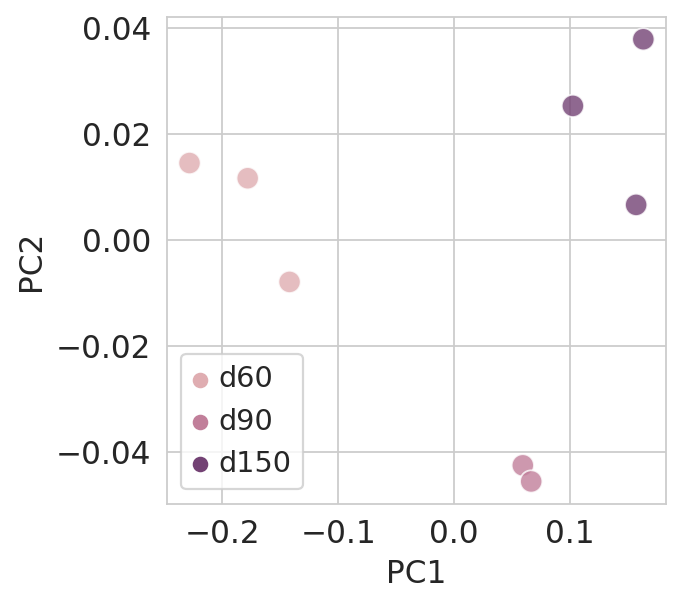

In [22]:
sns.scatterplot(data=pcoa_coordinates, x="PC1", y="PC2",
                hue="time point",
                s=100,
                alpha=0.8,
                palette=['#dfadb1','#c17f9a','#734274'],
#                 legend=False
               )
plt.legend(loc='lower left')
plt.savefig("./figures/PCoA_PC1_PC2.svg", bbox_inches='tight')

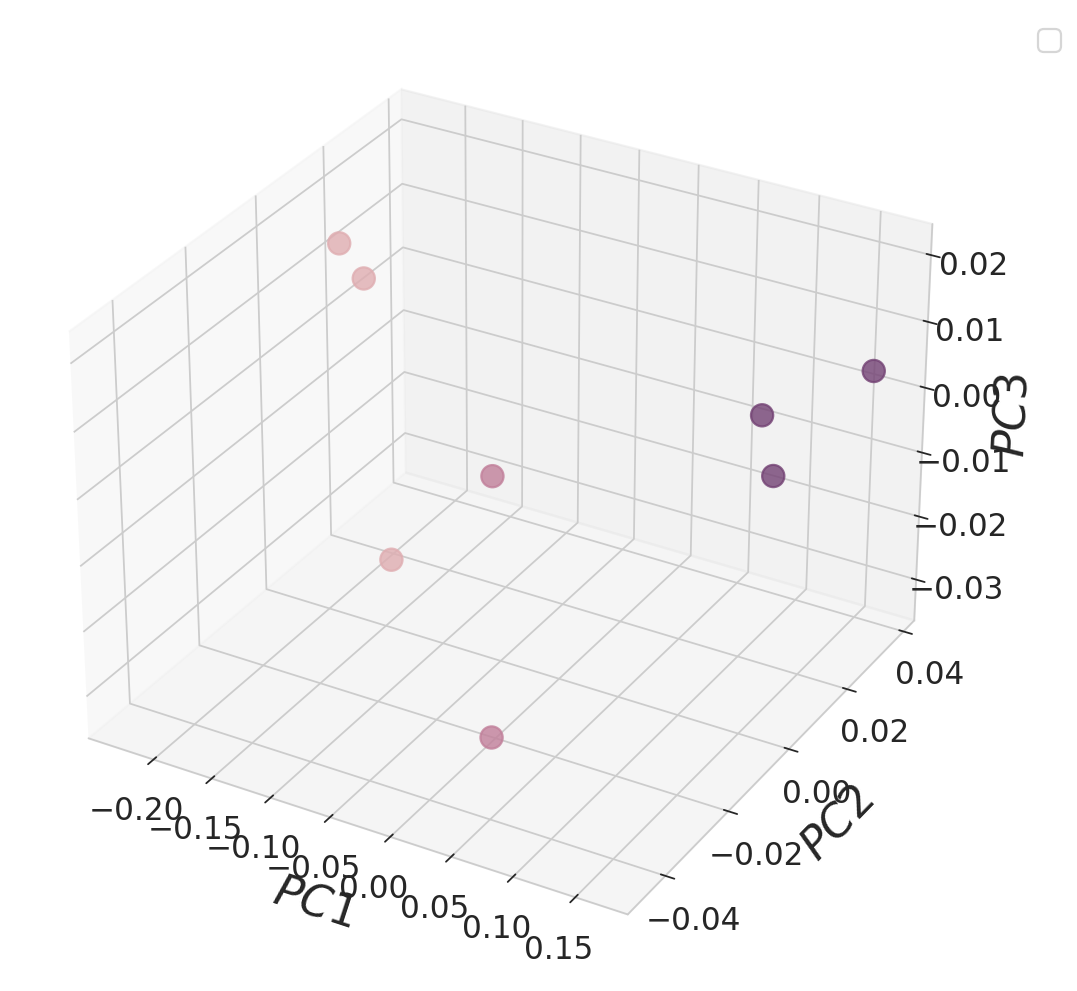

In [23]:

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# data
x = pcoa_coordinates["PC1"].values
y = pcoa_coordinates["PC2"].values
z = pcoa_coordinates["PC3"].values

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
fig.add_axes(ax)

# plot
sc = ax.scatter(x, y, z, s=100,
                c = ['#dfadb1','#dfadb1','#dfadb1',
                     '#c17f9a','#c17f9a',
                     '#734274','#734274','#734274'],
                marker= 'o', 
                alpha=0.8)

ax.set_xlabel('$PC1$', fontsize=20)
ax.set_ylabel('$PC2$', fontsize=20)
ax.set_zlabel('$PC3$', fontsize=20)

# ticks
# ax.set_xticks([-0.5, -0.2, 0, 0.2, 0.5])
# ax.set_yticks([-0.5, -0.2, 0, 0.2, 0.5])
# ax.set_zticks([-0.5, -0.2, 0, 0.2, 0.5])
# ax.set_ticks([-0.5, -0.2, 0, 0.2, 0.5])


# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
# plt.savefig("scatter_hue", bbox_inches='tight')